# Federated Learning from scratch with Pytorch
**A Pytorch implementation of the Federated Learning Algorithm FedAvg on MNIST dataset**

## Introduction
Federated Learning is a machine learning setting where many clients (e.g. mobile devices or whole organizations) collaboratively train a model under the orchestration of a central server (e.g. service provider), while keeping the training data decentralized. Federated Learning represents a possible solution to the problem of data privacy and data security in machine learning.

In this project I implemented the Federated Learning algorithm **FedAvg** formulated by McMahan, et al. [1] which is a first approach to this challange.

<img src="images/algo.png" alt="Image Description" width="400" height="400">

Basically the algorithm is divided into two phases: the **Client Update** and the **Server Update**. In the **Client Update** phase, each client trains its local model on its local sample of data for the number of local epochs, using the local batch size. In the **Server Update** phase, the server averages the models weights of all the clients to create a new global model. This global model is then sent to all the clients to start a new round of training. In this way, the server never has access to the raw data but only to the model weights, and the global model is a good approximation of the model that would have been obtained by training on the entire dataset.

## Implementation

I implemented the algorithm using Pytorch and I tested it on the MNIST dataset for semplicity. 

The project is divided into the following files:
- `fedsgd.py`: the main file that contains the implementation of the FedAvg algorithm
- `Client.py`: the file that contains the implementation of the `Client` class
- `Server.py`: the file that contains the implementation of the `Server` class
- `models.py`: the file that contains the implementation of the neural models

### Client
The `Client.py` file contains the implementation of the client class. Each client has its own dataloader, model and optimizer, the learning rate and the number of local epochs can be set by the user. The method `train` implements the **Client Update** phase.

```python
def train(self, num_epochs, patience, params, progress_bar):
    self.model.load_state_dict(params)
    self.model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (x, y) in enumerate(self.data):
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = self.loss_func(y_pred, y)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
        progress_bar.update(1)
    progress_bar.set_postfix({"loss": running_loss / len(self.data)})
    return running_loss / len(self.data)
```

### Server
The `Server.py` file contains the implementation of the server class. The server has a model and a list of clients, it also has the method `aggregate` that implements the **Server Update** phase. Notice that the function does not return the new global model but it updates the model inplace.

```python
def aggregate(self):
    params = [client.get_params() for client in self.clients]
    avg_params = {}
    for key in params[0].keys():
        avg_params[key] = torch.stack(
            [params[i][key] for i in range(len(params))], 0
        ).mean(0)
    self.model.load_state_dict(avg_params)
```

### Algorithm
Finally the `fedsgd.py` file contains the main function that runs the experiment with the right configuration. The algorithm run for `T` rounds, first the server get the current global model state and then sends it to all the clients. Next the clients train their local model, which they updated to the new one, moving into their local optimizer direction for local epochs step and then they send the model back to the server. The server aggregates the models and sends the new global model to all the clients. At the end of the training the server evaluates the model on the test set.

```python
def fedSgdPar(
    model=Cnn(),
    T=5,                # number of rounds
    K=10,               # number of clients
    C=1,                # fraction of clients
    E=10,               # number of local epochs
    B=128,              # local batch size
    num_samples=1000,   # number of training samples on each client
    lr=0.01,            # learning rate
    weight_decay=10e-6, # weight decay
    patience=5,         # patience for early stopping
):
    # ... code ...
    clients = []
    for i in range(num_clients):
        client = Client(
            i,
            trainloader[i],
            Cnn() if model.get_type() == "Cnn" else Net(),
            lr=lr,
            weight_decay=weight_decay,
            device=device,
        )
        clients.append(client)
    # ... code ...
    for r in range(T):
        params = server.get_params()
        progress_bar = tqdm.tqdm(
            total=E * num_clients, position=0, leave=False, desc="Round %d" % r
        )
        joblib.Parallel(n_jobs=num_clients, backend="threading")(
            joblib.delayed(client.train)(E, patience, params, progress_bar)
            for client in clients
        )
        server.aggregate()
        val_loss, val_acc = server.test(valoader)
        print("Server - Val loss: %.3f, Val accuracy: %.3f" % (val_loss, val_acc))
```

The dataset is splitted into training, validation and test set. The training set is divided into `K` clients, each client has a dataloader that samples `num_samples` samples from the training set. The validation set is used to evaluate the model at the end of each round, while the test set is used to evaluate the model at the end of the training. 

The parallel version uses the `joblilb` module to create a thread for each client, in this way we simulate better the real scenario where the clients are distributed on different devices and the training is done in parallel. In the experiments I will use this implementation.

This implemenation allows to test different configurations of the algorithm. In particular if we set `C = 1`, `E = 1` and `B = inf` we obtain the **FedSGD** algorithm, which is the baseline algorithm for the Federated Learning presented in the paper [1].

## Experiments
In this section I run some experimenst to test the algorithm on the MNIST dataset. First I tried to replicate the results of the paper [1] using the same configurations. 

In [1]:
from src.fedsgd import fedSgdPar
from src.models import Net, Cnn
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
result0 = fedSgdPar(model=Net(), T=20, K=100, C=0.1, E=5, B=10,
                    num_samples=480, lr=0.1, patience=5, weight_decay=10e-5)

Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=5, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=5
- Model: Net
- Data Split:  48000 12000 10000


Round 0: 100%|██████████| 50/50 [00:06<00:00, 10.27it/s, loss=0.107] 

Server - Val loss: 0.355, Val accuracy: 0.894


Round 1: 100%|██████████| 50/50 [00:06<00:00,  9.73it/s, loss=0.00851]

Server - Val loss: 0.325, Val accuracy: 0.908


Round 2: 100%|██████████| 50/50 [00:06<00:00, 10.20it/s, loss=0.00507]

Server - Val loss: 0.294, Val accuracy: 0.919


Round 3: 100%|██████████| 50/50 [00:06<00:00,  9.04it/s, loss=0.00355]

Server - Val loss: 0.268, Val accuracy: 0.927


Round 4: 100%|██████████| 50/50 [00:06<00:00,  9.19it/s, loss=0.00291]

Server - Val loss: 0.255, Val accuracy: 0.931


Round 5: 100%|██████████| 50/50 [00:06<00:00,  9.67it/s, loss=0.00197]

Server - Val loss: 0.240, Val accuracy: 0.936


Round 6: 100%|██████████| 50/50 [00:06<00:00,  9.41it/s, loss=0.00153]

Server - Val loss: 0.243, Val accuracy: 0.938


Round 7: 100%|██████████| 50/50 [00:06<00:00,  9.62it/s, loss=0.00166]

Server - Val loss: 0.232, Val accuracy: 0.941


Round 8: 100%|██████████| 50/50 [00:06<00:00,  9.34it/s, loss=0.0022] 

Server - Val loss: 0.232, Val accuracy: 0.942


Round 9: 100%|██████████| 50/50 [00:06<00:00,  9.18it/s, loss=0.00187]

Server - Val loss: 0.231, Val accuracy: 0.944


Round 10: 100%|██████████| 50/50 [00:06<00:00,  9.64it/s, loss=0.000878]

Server - Val loss: 0.228, Val accuracy: 0.945


Round 11: 100%|██████████| 50/50 [00:06<00:00,  9.67it/s, loss=0.00085] 

Server - Val loss: 0.226, Val accuracy: 0.945


Round 12: 100%|██████████| 50/50 [00:06<00:00,  9.35it/s, loss=0.000984]

Server - Val loss: 0.229, Val accuracy: 0.946


Round 13: 100%|██████████| 50/50 [00:06<00:00,  9.84it/s, loss=0.000899]

Server - Val loss: 0.234, Val accuracy: 0.946


Round 14: 100%|██████████| 50/50 [00:06<00:00,  9.69it/s, loss=0.000734]

Server - Val loss: 0.233, Val accuracy: 0.946


Round 15: 100%|██████████| 50/50 [00:06<00:00,  9.29it/s, loss=0.000695]

Server - Val loss: 0.233, Val accuracy: 0.947


Round 16: 100%|██████████| 50/50 [00:06<00:00,  9.16it/s, loss=0.000626]

Server - Val loss: 0.239, Val accuracy: 0.947


Round 17: 100%|██████████| 50/50 [00:06<00:00,  9.05it/s, loss=0.000584]

Server - Val loss: 0.241, Val accuracy: 0.946


Round 18: 100%|██████████| 50/50 [00:06<00:00,  9.87it/s, loss=0.000595]

Server - Val loss: 0.243, Val accuracy: 0.947


Round 19: 100%|██████████| 50/50 [00:06<00:00,  9.44it/s, loss=0.000552]

Server - Val loss: 0.246, Val accuracy: 0.947


-- Test loss: 0.220, Test accuracy: 0.951 --


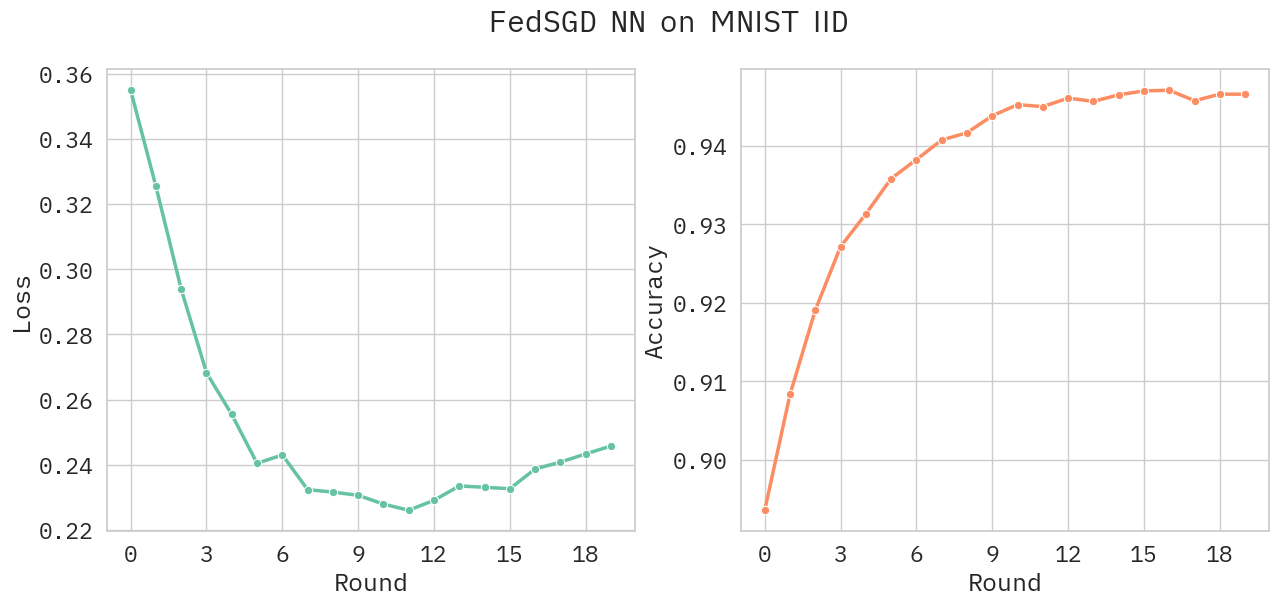

In [87]:
val_losses = result0['val_losses']
val_accs = result0['val_accs']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'iA Writer Quattro V'

sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[0], color=sns.color_palette()[0], marker='o')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Loss')

sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[1], color=sns.color_palette()[1], marker='o')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Accuracy')

fig.suptitle('FedSGD NN on MNIST IID')

for ax in axs:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [70]:
result1 = fedSgdPar(model=Cnn(), T=20, K=100, C=0.1, E=5, B=10,
                    num_samples=480, lr=0.01, patience=5, weight_decay=10e-5)

Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=20, K=100, C=0.1, E=5, B=10, num_samples=480, lr=0.01, weight_decay=0.0001, patience=5
- Model: Cnn
- Data Split:  48000 12000 10000


Round 0: 100%|██████████| 50/50 [00:11<00:00,  5.66it/s, loss=0.48] 

Server - Val loss: 0.408, Val accuracy: 0.893


Round 1: 100%|██████████| 50/50 [00:11<00:00,  5.46it/s, loss=0.223]

Server - Val loss: 0.249, Val accuracy: 0.927


Round 2: 100%|██████████| 50/50 [00:11<00:00,  5.58it/s, loss=0.113] 

Server - Val loss: 0.198, Val accuracy: 0.939


Round 3: 100%|██████████| 50/50 [00:10<00:00,  6.06it/s, loss=0.0592]

Server - Val loss: 0.174, Val accuracy: 0.948


Round 4: 100%|██████████| 50/50 [00:09<00:00,  5.48it/s, loss=0.0417]

Server - Val loss: 0.154, Val accuracy: 0.954


Round 5: 100%|██████████| 50/50 [00:10<00:00,  5.90it/s, loss=0.0298]

Server - Val loss: 0.143, Val accuracy: 0.958


Round 6: 100%|██████████| 50/50 [00:09<00:00,  6.27it/s, loss=0.0152]

Server - Val loss: 0.134, Val accuracy: 0.961


Round 7: 100%|██████████| 50/50 [00:10<00:00,  5.81it/s, loss=0.0199]

Server - Val loss: 0.128, Val accuracy: 0.963


Round 8: 100%|██████████| 50/50 [00:10<00:00,  6.27it/s, loss=0.0164] 

Server - Val loss: 0.124, Val accuracy: 0.965


Round 9: 100%|██████████| 50/50 [00:10<00:00,  5.98it/s, loss=0.00769]

Server - Val loss: 0.120, Val accuracy: 0.966


Round 10: 100%|██████████| 50/50 [00:10<00:00,  5.81it/s, loss=0.00838]

Server - Val loss: 0.119, Val accuracy: 0.967


Round 11: 100%|██████████| 50/50 [00:11<00:00,  5.43it/s, loss=0.00613]

Server - Val loss: 0.116, Val accuracy: 0.968


Round 12: 100%|██████████| 50/50 [00:10<00:00,  5.82it/s, loss=0.00661]

Server - Val loss: 0.113, Val accuracy: 0.969


Round 13: 100%|██████████| 50/50 [00:09<00:00,  5.93it/s, loss=0.00431]

Server - Val loss: 0.111, Val accuracy: 0.969


Round 14: 100%|██████████| 50/50 [00:10<00:00,  5.62it/s, loss=0.00817]

Server - Val loss: 0.109, Val accuracy: 0.969


Round 15: 100%|██████████| 50/50 [00:10<00:00,  5.47it/s, loss=0.00473]

Server - Val loss: 0.109, Val accuracy: 0.971


Round 16: 100%|██████████| 50/50 [00:10<00:00,  5.88it/s, loss=0.00299]

Server - Val loss: 0.107, Val accuracy: 0.971


Round 17: 100%|██████████| 50/50 [00:10<00:00,  5.04it/s, loss=0.00376]

Server - Val loss: 0.106, Val accuracy: 0.971


Round 18: 100%|██████████| 50/50 [00:11<00:00,  5.60it/s, loss=0.003]  

Server - Val loss: 0.106, Val accuracy: 0.971


Round 19: 100%|██████████| 50/50 [00:11<00:00,  5.73it/s, loss=0.00322]

Server - Val loss: 0.106, Val accuracy: 0.971


-- Test loss: 0.086, Test accuracy: 0.975 --


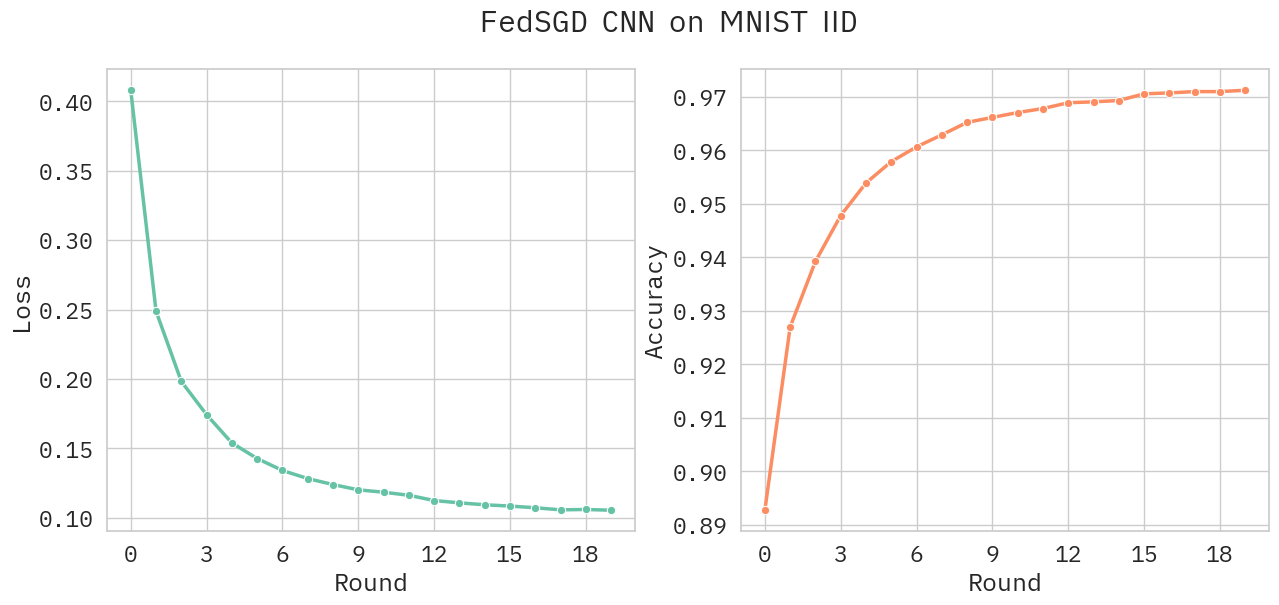

In [88]:
val_losses = result1['val_losses']
val_accs = result1['val_accs']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, 'axes.labelsize': 18})
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'iA Writer Quattro V'

sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=axs[0], color=sns.color_palette()[0], marker='o')
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Loss')

sns.lineplot(x=range(len(val_accs)), y=val_accs, ax=axs[1], color=sns.color_palette()[1], marker='o')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Accuracy')

fig.suptitle('FedSGD CNN on MNIST IID')

for ax in axs:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

Then I run the algorithm with different values of E. 

In [ ]:
results = {}
for model in [Net(), Cnn()]:
    results[model.get_type()] = {}
    for E in [1, 3, 5, 10, 15]:
        print(f'E = {E}')
        result = fedSgdPar(model=model,
                            T=20, K=100, C=0.1, E=E, B=10, num_samples=480, lr=0.1,
                            patience=400, weight_decay=10e-5, verbose=False)
        results[model.get_type()][E] = result


Non IID

In [2]:
result = fedSgdPar(model=Net(), T=5, K=100, C=0.1, E=5, B=10,
                     num_samples=480, lr=0.1, patience=5, weight_decay=10e-5, noiid=True)

Running the Parallel implementation FedSGD on MNIST dataset
- Parameters: T=5, K=100, C=0.1, E=5, B=10, num_samples=480, lr=0.1, weight_decay=0.0001, patience=5
- Model: Net
- Data Split:  48000 12000 10000
Using non-IID data


Round 0:   0%|          | 0/50 [00:00<?, ?it/s]

IndexError: list index out of range

## Results

## Considerations

## References
[1] [H. B. McMahan, E. Moore, D. Ramage, S. Hampson, and B. A. y Arcas, Communication-Efficient Learning of Deep Networks from Decentralized Data. 2023.](https://arxiv.org/abs/1602.05629)

## TODO 
- [x] Add implementation code description: 
	- [x] `Client` class
	- [x] `Server` class
	- [x] `models` class
	- [x] `fedSgdPar` and `fedSgd` algorithm (show the algorithm code)
- [x] Check parallel client implementation (can be improved?)
- [ ] Add LSTM model
- [ ] Run experiment (from the paper)
- [ ] Show results
- [x] Code refactoring: move the class in separate files and the main code in a separate file

## ROUTMAP ESPERIMENTI
1. Replica risultati paper
   1. Confronta i diversi modelli 
   2. Prova alcune configurazioni
2. Ablation study su E
3. Esperimenti su dati non iid


Domande: 
- Notebook 
- Esperimenti 
- Aggiunte (early stopping, altri modelli, altri dataset, etc.)

RISPOSTE: 
- Early stopping inutile
- Compara risultati con paper cerca di replicare i risultati
- La cosa interessante e' vedere come cambia aumentando E il numero di iterazioni locali
- Perche' la differenza tra fedsgd e fedavg sta in E 
- Di fatto si dovrebbe vedere che aumentando troppo E si rompe la convergenza 
- E = 1 -> FedSGD 
- E > 1 -> FedAvg funziona ma per E troppo grande non funziona piu'
- Confronto dati iid e non iid e' interessante 
- Importante come gestisco e implemento i client paralleli (la parte piu' difficile da implementare)


